# Well and Grace Drought Analysis Code
Written by Danielle Tadych

 The purpose of this script is to analyze our master water level database and GRACE data for various types of drought. 

## Loading packages and files

In [84]:
import Custom_functions
from optparse import Values
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.colors import ListedColormap
import datetime
from matplotlib.transforms import Bbox
import numpy as np
import pandas as pd
from shapely.geometry import box
import geopandas as gp
#import earthpy as et
import scipy.stats as sp
from scipy.stats import kendalltau, pearsonr, spearmanr
import pymannkendall as mk

# Data paths
datapath = '../Data/Input_files/'
outputpath = '../Data/Output_files/'
shapepath = '../Data/Shapefiles/'
figurepath = '../Data/Figures/'

In [9]:
# %%  ==== Reading in the data ====
filename_georeg = 'georeg_reproject_fixed.shp'
filepath = os.path.join(shapepath, filename_georeg)
georeg = gp.read_file(filepath)
# georeg.plot(cmap='viridis')

georeg['GEOREGI_NU'] = georeg['GEOREGI_NU'].astype('int64')
georeg.info()

# Read in the annual time series database
filename_ts = 'Wells55_GWSI_WLTS_DB_annual.csv'
filepath = os.path.join(datapath, filename_ts)
print(filepath)
annual_db = pd.read_csv(filepath, header=1, index_col=0)

annual_db.index.astype('int64')
annual_db2 = annual_db.reset_index(inplace=True)
annual_db2 = annual_db.rename(columns = {'year':'Combo_ID'})
annual_db2.head()

# For regulation
filepath = datapath+'Waterlevels_Regulation.csv'
cat_wl2_reg = pd.read_csv(filepath, index_col=0)
cat_wl2_reg.head()

# For Access to SW
filepath = datapath+'Waterlevels_AccesstoSW.csv'
cat_wl2_SW = pd.read_csv(filepath, index_col=0)
cat_wl2_SW.head()

# For georegion number
filepath = datapath+'Waterlevels_georegions.csv'
cat_wl2_georeg = pd.read_csv(filepath, index_col=0)

# Read in the drought indices
drought_indices = pd.read_csv(datapath+'Yearly_DroughtIndices.csv')
drought_indices = drought_indices.set_index('In_year')
# drought_indices

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   GEO_Region  11 non-null     object  
 1   GEOREGI_NU  11 non-null     int64   
 2   Water_CAT   11 non-null     object  
 3   Loc         11 non-null     object  
 4   Regulation  11 non-null     object  
 5   geometry    11 non-null     geometry
dtypes: geometry(1), int64(1), object(4)
memory usage: 656.0+ bytes
../Data/Input_files/Wells55_GWSI_WLTS_DB_annual.csv


In [10]:
# %% Creating colors
c_1 = '#8d5a99' # Reservation
c_2 = "#d7191c" # Regulated with CAP (Water Category Color)
c_3 = '#e77a47' # Regulated without CAP (Water Category Color)
c_4 = '#2cbe21' # Lower CO River - SW (Water Category Color)
c_5 = '#2f8c73' # Upper CO River - Mixed (Water Category Color)
c_6 = '#6db7e8' # SE - GW
c_7 = '#165782' # NW - GW (Water Category color)
c_8 = '#229ce8' # SC - GW
c_9 = '#1f78b4' # NE - GW
c_10 = '#41bf9e' # N - Mixed
c_11 = '#7adec4' # C - Mixed
drought_color = '#ffa6b8'
wet_color = '#b8d3f2'

reg_colors = [c_2,c_7]
georeg_colors = [c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,c_10,c_11]
SW_colors = [c_2,c_3,c_4,c_5,c_7]

bar_watercatc = [c_2,c_3,c_4,c_5,c_7]


# Color blind palette
# https://jacksonlab.agronomy.wisc.edu/2016/05/23/15-level-colorblind-friendly-palette/
blind =["#000000","#004949","#009292","#ff6db6","#ffb6db",
 "#490092","#006ddb","#b66dff","#6db6ff","#b6dbff",
 "#920000","#924900","#db6d00","#24ff24","#ffff6d"]

# Matching new map

cap = '#C6652B'
# noCAP = '#EDE461' # This is one from the map
noCAP = '#CCC339' # This color but darker for lines
GWdom = '#3B76AF'
mixed = '#6EB2E4'
swdom = '#469B76'

## Analysis
Wanting to look at 
1) Maximum Drawdown compared to the trend 
2) Anomalies 
3) Recovery

Decided from the drought indices analysis that the cutoff value is -3 for severe droughts


In [11]:
# %% Drought dictionary
DROUGHT_YEARS = {1:[1989,1990]
        ,2:[1996]
        ,3:[2002,2003]
        ,4:[2006,2007]
        ,5:[2012,2013,2014]
        ,6:[2018]}

print(DROUGHT_YEARS)

{1: [1989, 1990], 2: [1996], 3: [2002, 2003], 4: [2006, 2007], 5: [2012, 2013, 2014], 6: [2018]}


In [63]:
#%% Pre-drought
# PREDROUGHT_YEARS = {1:[1988]
#         ,2:[1995]
#         ,3:[2001]
#         ,4:[2005]
#         ,5:[2011]
#         ,6:[2017]}

PREDROUGHT_YEARS = {1:[*range(1975,1988,1)]
        ,2:[*range(1991,1995,1)]
        ,3:[*range(1997,2001,1)]
        ,4:[*range(2004,2005,1)]
        ,5:[*range(2006,2011,1)]
        ,6:[*range(2015,2017,1)]}

print(PREDROUGHT_YEARS)

{1: [1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987], 2: [1991, 1992, 1993, 1994], 3: [1997, 1998, 1999, 2000], 4: [2004], 5: [2006, 2007, 2008, 2009, 2010], 6: [2015, 2016]}


In [64]:
#%% Print the average PDSI and PHDI values

ds = drought_indices.copy()
columns = ds.columns
column_list = ds.columns.tolist()

ds['Status'] = 'Normal-Wet'
# wlanalysis_period

for x,y in DROUGHT_YEARS.items():
        ds.loc[y, 'Status'] = 'Drought '+str(x)


pdsi_avg = ds.groupby(['Status']).mean()
pdsi_avg

,PDSI,PHDI
Status,,
Drought 1,-2.281250,-2.974167
Drought 2,-4.137500,-4.137500
Drought 3,-4.109167,-4.109167
Drought 4,-3.658750,-3.658750
Drought 5,-3.164722,-3.164722
Drought 6,-3.342500,-4.258333
Normal-Wet,0.202024,0.335333


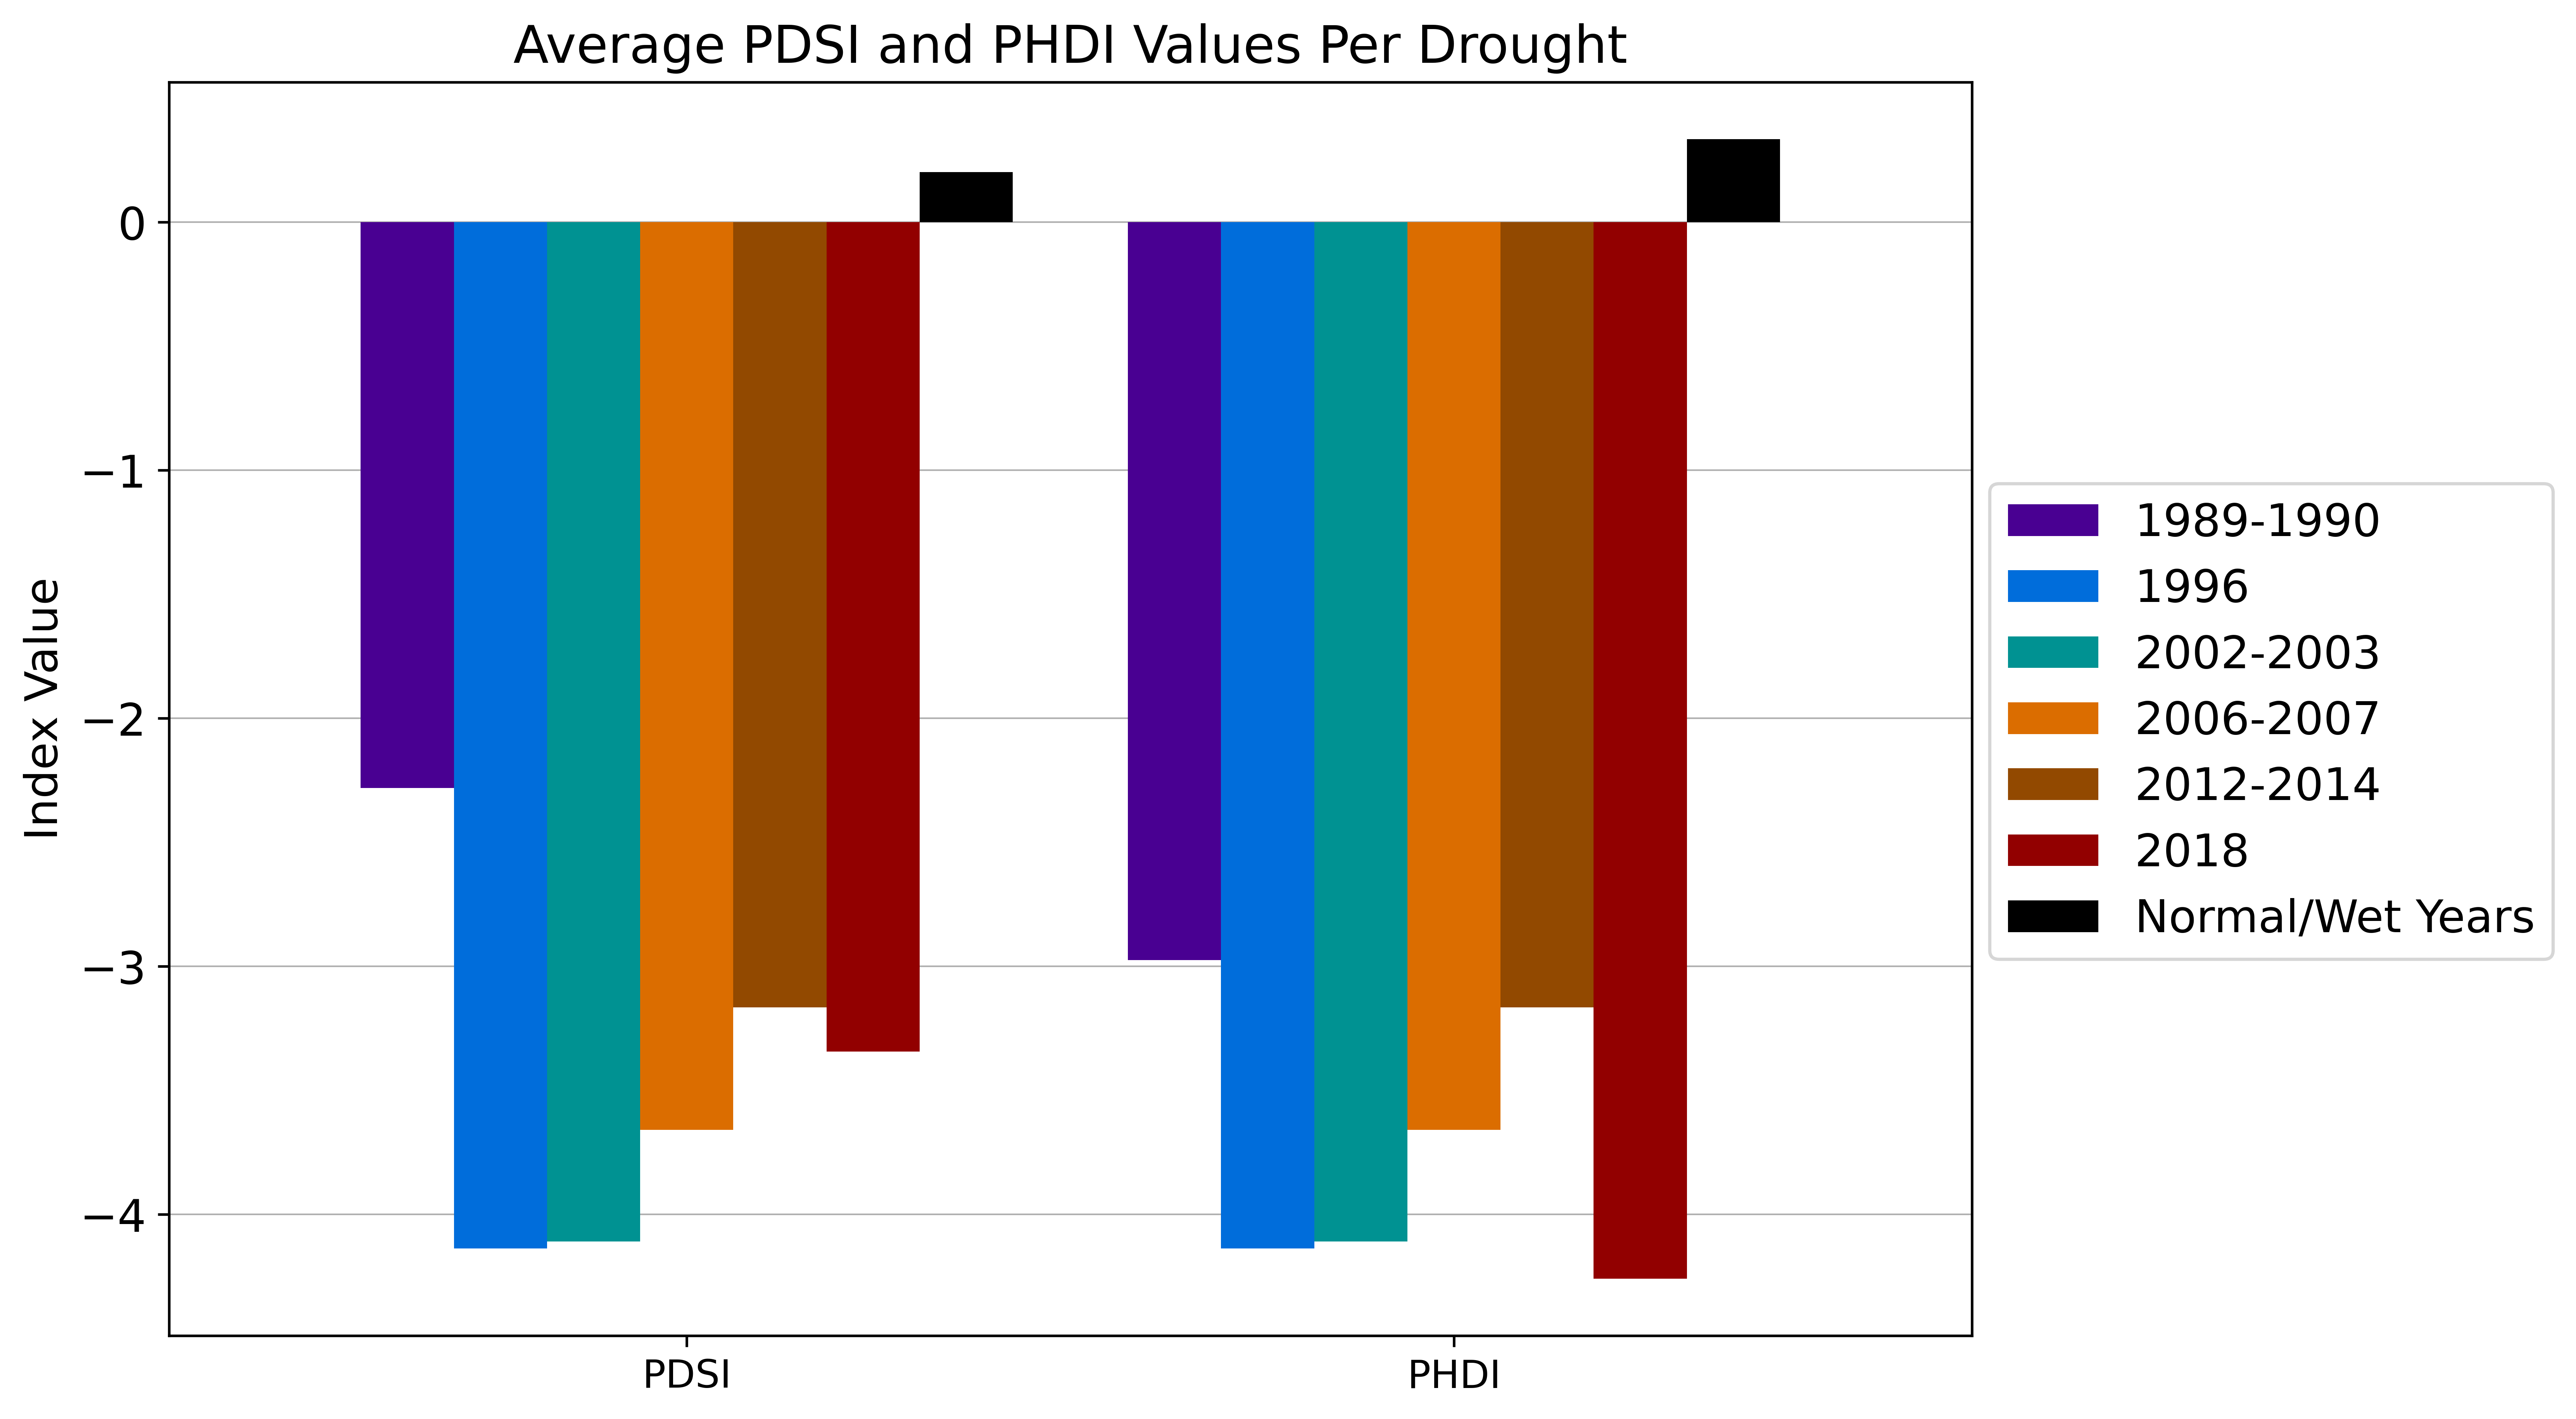

In [65]:
name = 'Average PDSI and PHDI Values Per Drought'

yearlabels = ["1989-1990"
                ,'1996'
                ,'2002-2003'
                ,'2006-2007'
                ,'2012-2014'
                ,'2018'
                ,'Normal/Wet Years']

pdsi_avg.index = yearlabels
pdsi_avg = pdsi_avg.transpose()
# del ds['Normal/Wet Years']
pdsi_avg
#%%
group_colors = [blind[5],blind[6],blind[2]
                ,blind[12],blind[11],blind[10]
                ,blind[0] #black
                ]

horlabel = 'Index Value'
fsize = 14

plt.rcParams["figure.dpi"] = 600
pdsi_avg.plot(figsize = (10,7),
        kind='bar',
        stacked=False,
        # title=name,
        color = group_colors,
        zorder = 2,
        width = 0.85,
        fontsize = fsize
        )
plt.title(name, fontsize = (fsize+2))
# plt.ylim([0,400])
plt.ylabel(horlabel, fontsize = fsize)
plt.xticks(rotation=0, fontsize = fsize-2)
plt.grid(axis='y', linewidth=0.5, zorder=0)
plt.legend(loc=[1.01,0.3],fontsize = fsize)

# plt.savefig(outputpath+name+'_groupedchart', bbox_inches = 'tight')

In [66]:
# %% Figure out which water level database you want
cat_wl2 = cat_wl2_reg.copy() 
# cat_wl2 = cat_wl2_SW.copy()
# cat_wl2 = cat_wl2_georeg.copy()

# cat_wl2 = wdc1_reg.copy()
# cat_wl2 = wdc2_reg.copy()
# cat_wl2 = wdc3_reg.copy()
# cat_wl2 = wdc1_SW.copy()
# cat_wl2 = wdc2_SW.copy()
# cat_wl2 = wdc3_SW.copy()

# Water Analysis period
wlanalysis_period = cat_wl2[cat_wl2.index>=1975]
# wlanalysis_period["UGW"]=wlanalysis_period['GW']
# del wlanalysis_period['GW']
# wlanalysis_period

In [98]:
# Anomaly's
ds = wlanalysis_period.copy()
columns = ds.columns
column_list = ds.columns.tolist()

dtw_anomalys = pd.DataFrame()
for i in column_list:
        # Subtracting against the mean
        # dtw_anomalys[i] = wlanalysis_period[i] - wlanalysis_period[i].mean()
        
        # Subtracting against the slope
        df = ds[i]
        y=np.array(df.values, dtype=float)
        x=np.array(pd.to_datetime(df).index.values, dtype=float)
        slope, intercept, r_value, p_value, std_err = sp.linregress(x,y)
        # print(y)
        # slope, intercept = sp.linregress(x,y) 
        dtw_anomalys[i] = wlanalysis_period[i] - ((wlanalysis_period.index*slope) + intercept)

dtw_anomalys

,R,U
index,,
1975,9.613013,21.969728
1976,1.727506,1.749720
1977,5.507541,-4.634793
1978,1.267475,-4.803269
1979,-6.642692,-14.790455
1980,-5.967806,-2.288922
1981,3.121357,0.327804
1982,11.963378,8.163858
1983,11.977876,11.448223


In [102]:
# %% Average Anomalie for drought periods
ds = dtw_anomalys.copy()
columns = ds.columns
column_list = ds.columns.tolist()

ds['Status'] = 'Normal-Wet'
# wlanalysis_period

for x,y in DROUGHT_YEARS.items():
        ds.loc[y, 'Status'] = 'Drought '+str(x)


dtw_mean_anomalies = ds.groupby(['Status']).mean()
dtw_mean_anomalies
# ds

,R,U
Status,,
Drought 1,-17.979316,-9.114450
Drought 2,-34.211052,-27.311164
Drought 3,27.652019,9.912070
Drought 4,9.221969,12.027516
Drought 5,-2.576413,5.519885
Drought 6,11.266108,12.547603
Normal-Wet,-0.203290,-0.784182


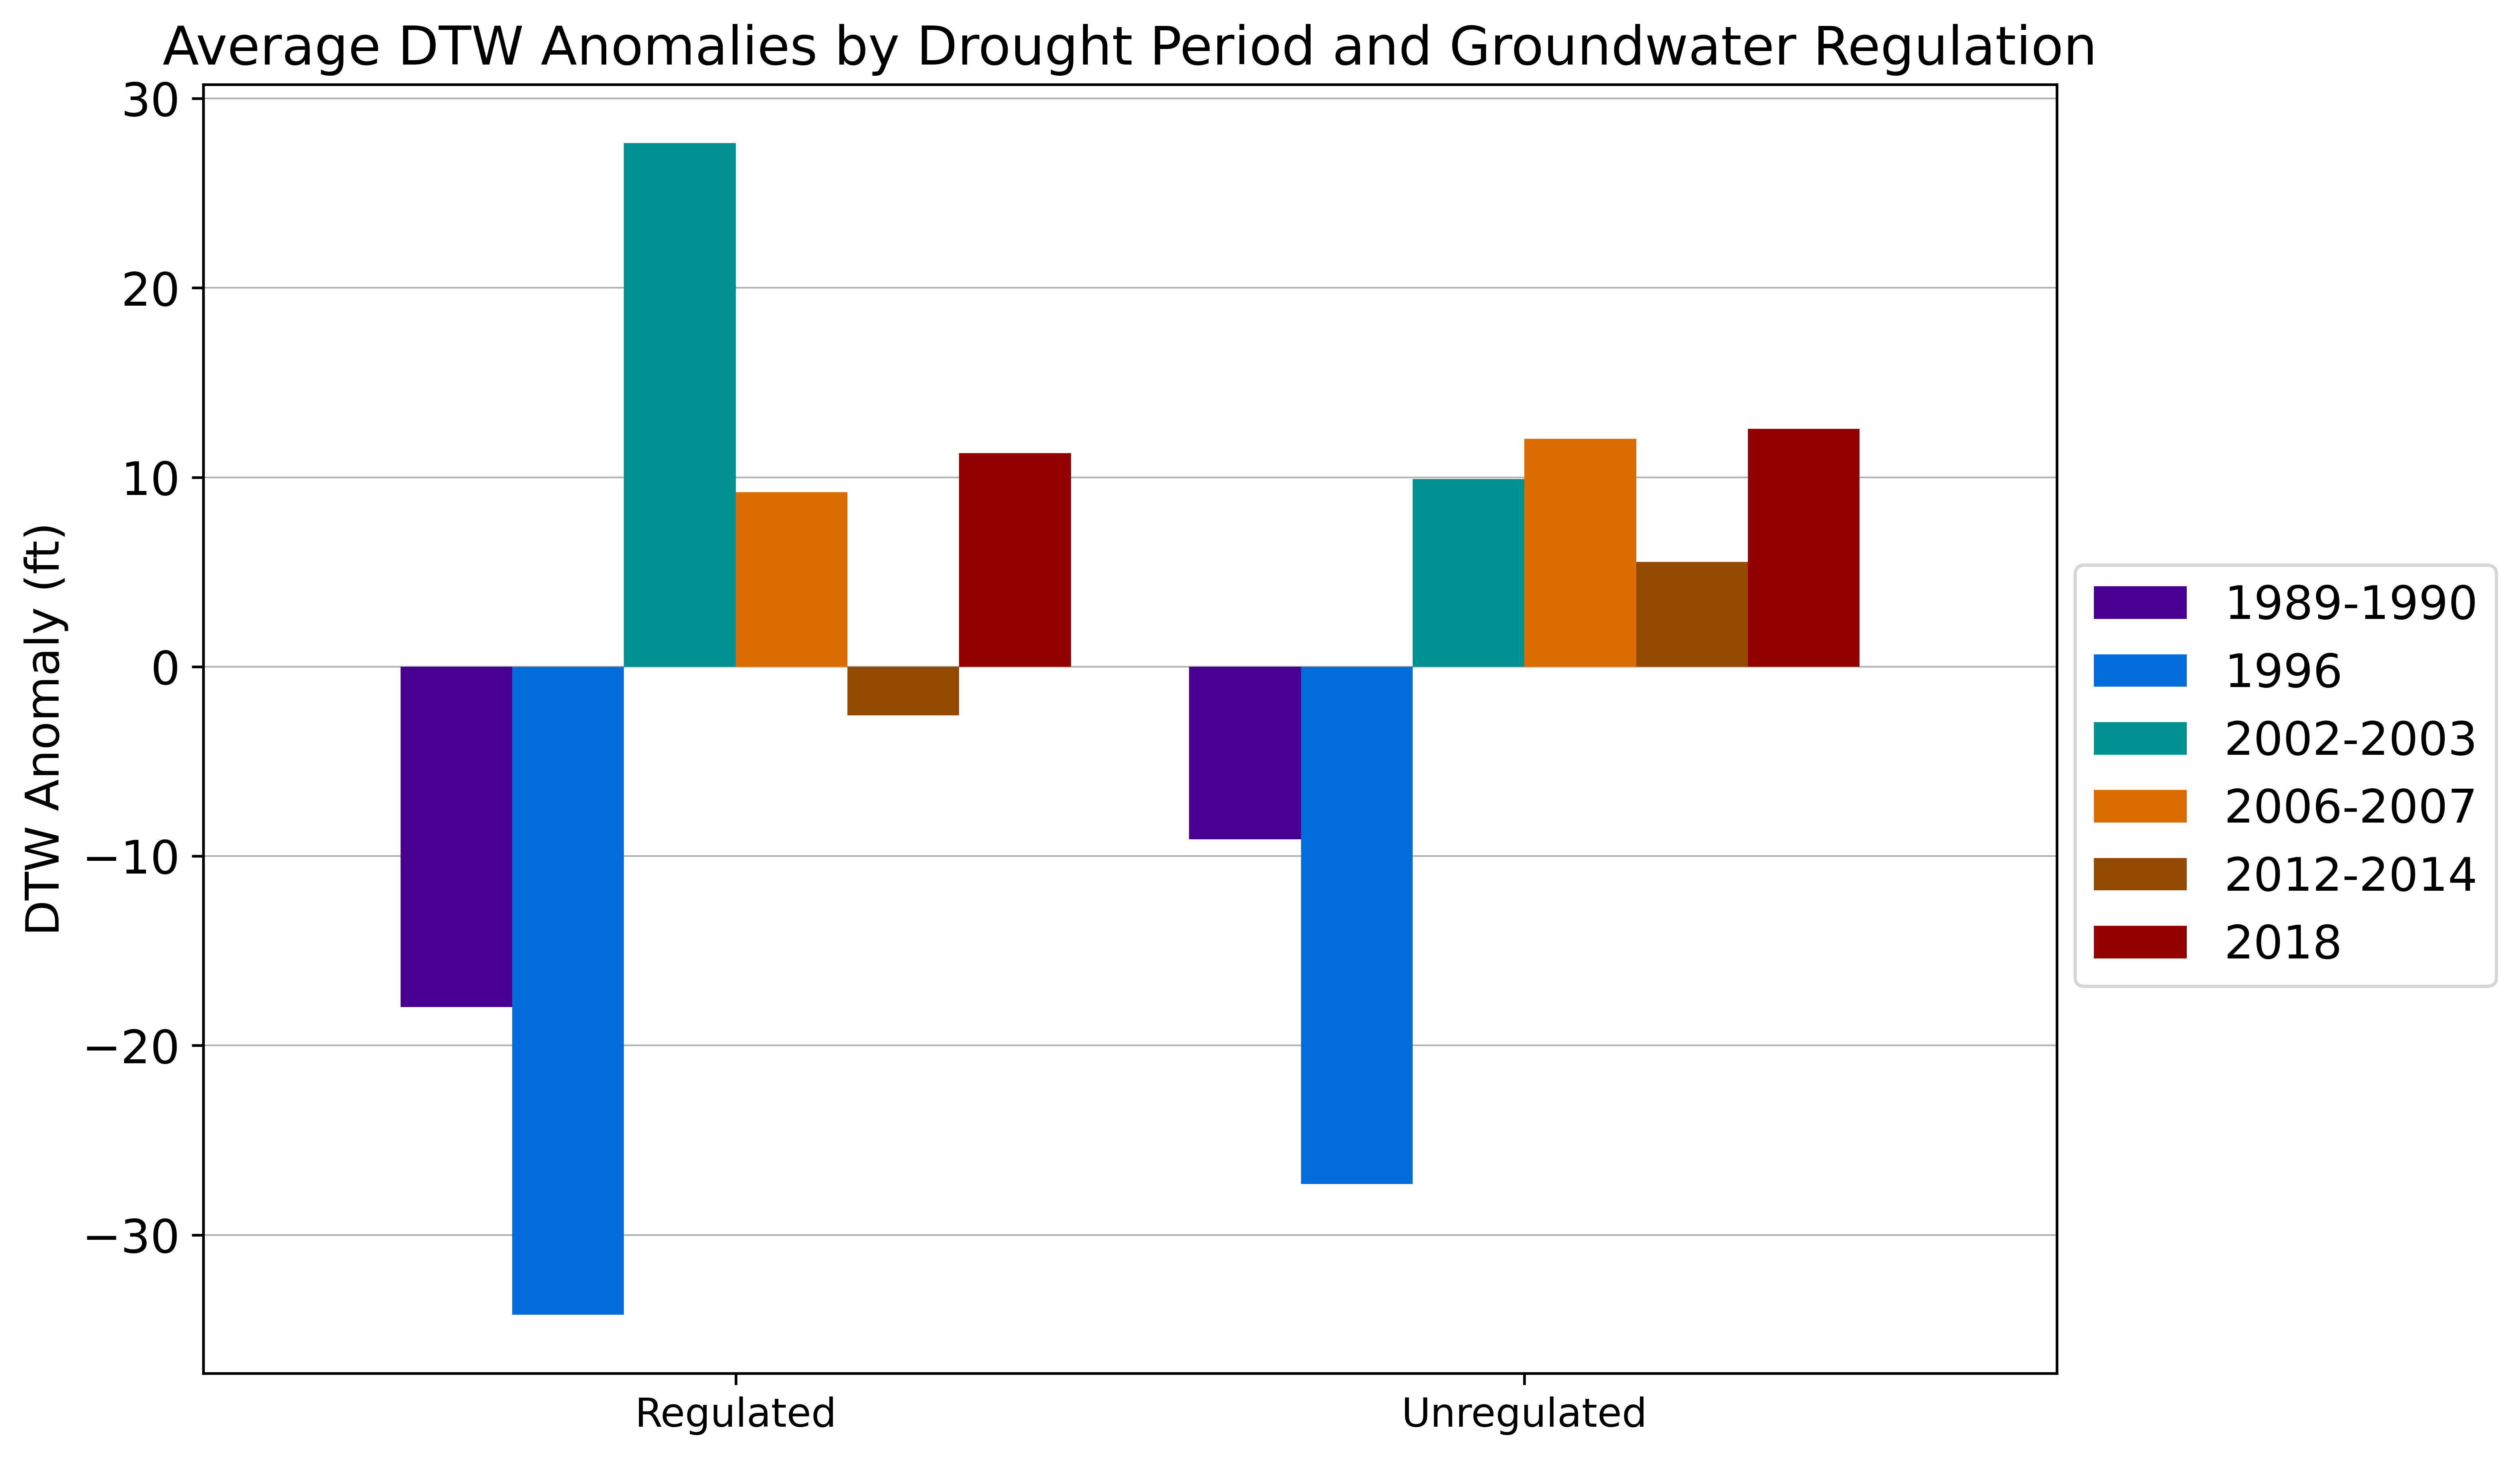

In [103]:
#%% Grouped Bar chart for drawdown (ft)
name = 'Average DTW Anomalies by Drought Period and Groundwater Regulation'
# name = 'Max Drawdown by Drought Period and Access to SW'

yearlabels = ["1989-1990",'1996','2002-2003','2006-2007','2012-2014','2018','Normal/Wet Years']
# betterlabels = ['CAP','Regulated \n Groundwater','Surface \n Water','Unregulated \n Groundwater','Mixed \n GW/SW'] 
betterlabels = ['Regulated','Unregulated']

dtw_mean_anomalies.index = yearlabels
dtw_mean_anomalies = dtw_mean_anomalies.transpose()

dtw_mean_anomalies.index = betterlabels
del dtw_mean_anomalies['Normal/Wet Years']
dtw_mean_anomalies


# group_colors = ['lightsalmon','tomato','orangered','r','brown','indianred','steelblue']

group_colors = [blind[5],blind[6],blind[2]
                ,blind[12],blind[11],blind[10]
                # ,blind[0] #black
                ]

horlabel = 'DTW Anomaly (ft)'
fsize = 14

plt.rcParams["figure.dpi"] = 600
dtw_mean_anomalies.plot(figsize = (10,7),
        kind='bar',
        stacked=False,
        # title=name,
        color = group_colors,
        zorder = 2,
        width = 0.85,
        fontsize = fsize
        )
plt.title(name, fontsize = (fsize+2))
# plt.ylim([0,400])
plt.ylabel(horlabel, fontsize = fsize)
plt.xticks(rotation=0, fontsize = fsize-2)
plt.grid(axis='y', linewidth=0.5, zorder=0)
plt.legend(loc=[1.01,0.3],fontsize = fsize)
# plt.set_dpi(600)

plt.savefig(figurepath+name+'_groupedchart', bbox_inches = 'tight')
# plt.savefig(outputpath+name+'_anomalies_SWAccess_groupedchart', bbox_inches = 'tight')

In [68]:
# %% Max drawdown
ds = wlanalysis_period.copy()
columns = ds.columns
column_list = ds.columns.tolist()

ds['Status'] = 'Normal-Wet'
# wlanalysis_period

for x,y in DROUGHT_YEARS.items():
        ds.loc[y, 'Status'] = 'Drought '+str(x)


drawd_max = ds.groupby(['Status']).max()
drawd_max
# ds

,R,U
Status,,
Drought 1,180.712773,159.418976
Drought 2,164.610175,151.940624
Drought 3,238.270432,209.671952
Drought 4,224.220432,217.820875
Drought 5,227.468807,228.765211
Drought 6,238.833255,235.502765
Normal-Wet,230.834913,232.780097


In [69]:
PREDROUGHT_YEARS

{1: [1975,
  1976,
  1977,
  1978,
  1979,
  1980,
  1981,
  1982,
  1983,
  1984,
  1985,
  1986,
  1987],
 2: [1991, 1992, 1993, 1994],
 3: [1997, 1998, 1999, 2000],
 4: [2004],
 5: [2006, 2007, 2008, 2009, 2010],
 6: [2015, 2016]}

This is for calculating against the average for Normal-Wet periods

In [70]:
# Predrought values
ds = wlanalysis_period.copy()
columns = ds.columns
column_list = ds.columns.tolist()

ds['Status'] = 'Normal-Wet'

for x,y in PREDROUGHT_YEARS.items():
        ds.loc[y, 'Status'] = 'Drought '+str(x)

ds
predrought = ds.groupby(['Status']).mean()
predrought

,R,U
Status,,
Drought 1,184.064133,152.233825
Drought 2,170.331708,159.767962
Drought 3,212.335055,188.709985
Drought 4,225.849473,195.042627
Drought 5,214.046204,201.943075
Drought 6,216.945755,223.454407
Normal-Wet,210.733020,197.531387


Now for calculating against the slope

In [71]:
# Predrought values
import pandas as pd
ds = wlanalysis_period.copy()
columns = ds.columns
column_list = ds.columns.tolist()

labels = ['R','U']
stats = pd.DataFrame()
for i in column_list:
        df = ds[i]
        # df = f[i].pct_change()
        #print(df)
        y=np.array(df.values, dtype=float)
        x=np.array(pd.to_datetime(df).index.values, dtype=float)
        slope, intercept, r_value, p_value, std_err =sp.linregress(x,y)
        stats = stats._append({'slope': slope,
                               'int':intercept
                        },
                        ignore_index=True)


stats.index = labels
stats1 = stats.transpose()
stats1

,R,U
slope,1.306633,1.986517
int,-2409.217735,-3785.836173


y = m x + b

y is the value
m is stats1[i,'slope']
b is stats1[i,'slope']

In [28]:
stats1.loc['slope','R']

1.306632746899067

In [73]:
# Predrought values
ds = wlanalysis_period.copy()
columns = ds.columns
column_list = ds.columns.tolist()

ds['Status'] = 'Normal-Wet'

for x,y in PREDROUGHT_YEARS.items():
        ds.loc[y, 'Status'] = 'Drought '+str(x)

ds
# predrought = ds.groupby(['Status']).mean()
# predrought

,R,U,Status
index,,,
1975,180.994953,159.504658,Drought 1
1976,174.416079,141.271168,Drought 1
1977,179.502746,136.873172,Drought 1
1978,176.569313,138.691213,Drought 1
1979,169.965778,130.690543,Drought 1
1980,171.947298,145.178593,Drought 1
1981,182.343093,149.781837,Drought 1
1982,192.491747,159.604408,Drought 1
1983,193.812877,164.875290,Drought 1


In [74]:
# ds = predrought
predrought_slope = ds.copy()
for i in column_list:
    print(i)
    m = stats1.loc['slope',i]
    b = stats1.loc['int',i]
    x = predrought_slope[i].index*m + b
    # print(x)
    predrought_slope[i] = x
#     predrought_slope = predrought_slope._append(x)

predrought_slope
    

R
U


,R,U,Status
index,,,
1975,171.381940,137.534930,Drought 1
1976,172.688572,139.521447,Drought 1
1977,173.995205,141.507964,Drought 1
1978,175.301838,143.494481,Drought 1
1979,176.608471,145.480998,Drought 1
1980,177.915103,147.467515,Drought 1
1981,179.221736,149.454032,Drought 1
1982,180.528369,151.440549,Drought 1
1983,181.835002,153.427066,Drought 1


In [75]:
predrought = predrought_slope.groupby(['Status']).mean()
predrought

,R,U
Status,,
Drought 1,179.221736,149.454032
Drought 2,194.248013,172.298978
Drought 3,202.087809,184.218080
Drought 4,209.274289,195.143924
Drought 5,214.500820,203.089992
Drought 6,224.300566,217.988869
Normal-Wet,211.195808,198.065272


In [86]:
# %% Drawdown
drawdown = drawd_max - predrought
# del drawdown['Status']
drawdown

,R,U
Status,,
Drought 1,1.491037,9.964944
Drought 2,-29.637838,-20.358354
Drought 3,36.182623,25.453872
Drought 4,14.946142,22.676951
Drought 5,12.967987,25.675219
Drought 6,14.532690,17.513895
Normal-Wet,19.639105,34.714824


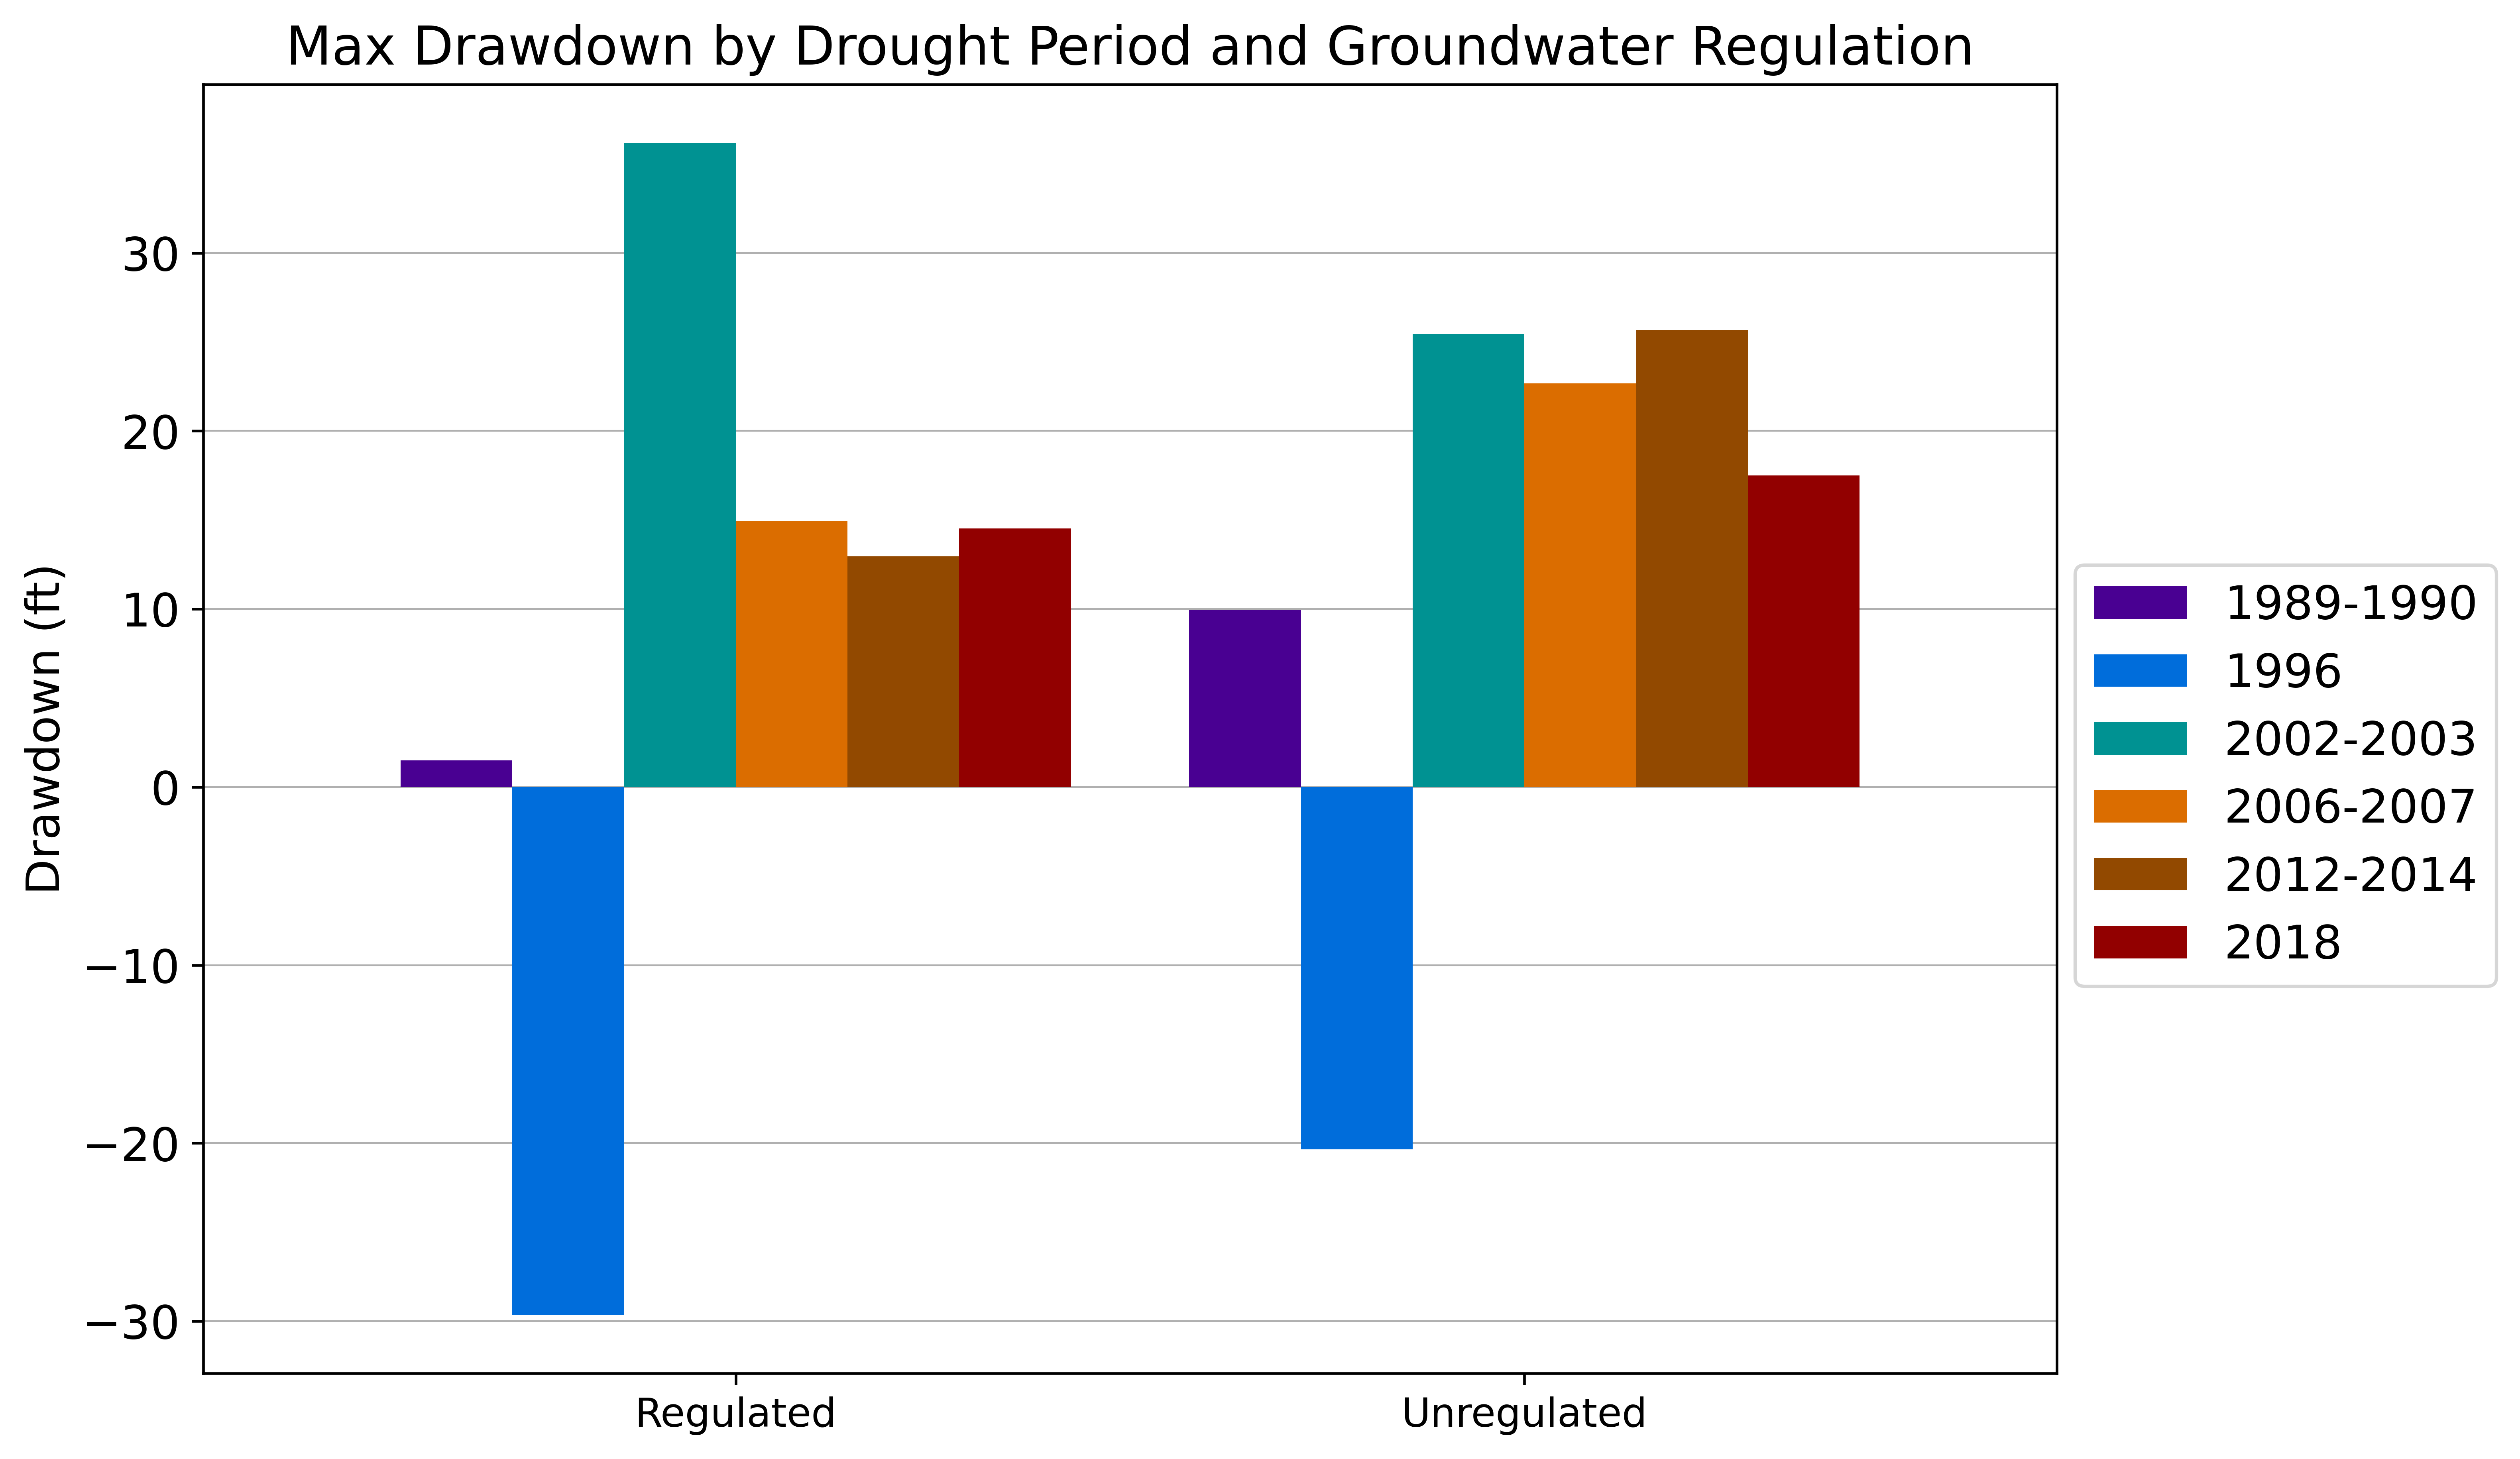

In [87]:
#%% Grouped Bar chart for drawdown (ft)
name = 'Max Drawdown by Drought Period and Groundwater Regulation'
# name = 'Max Drawdown by Drought Period and Access to SW'

yearlabels = ["1989-1990",'1996','2002-2003','2006-2007','2012-2014','2018','Normal/Wet Years']
# betterlabels = ['CAP','Regulated \n Groundwater','Surface \n Water','Unregulated \n Groundwater','Mixed \n GW/SW'] 
betterlabels = ['Regulated','Unregulated']

drawdown.index = yearlabels
drawdown = drawdown.transpose()
drawdown
drawdown.index = betterlabels
del drawdown['Normal/Wet Years']
drawdown


# group_colors = ['lightsalmon','tomato','orangered','r','brown','indianred','steelblue']

group_colors = [blind[5],blind[6],blind[2]
                ,blind[12],blind[11],blind[10]
                # ,blind[0] #black
                ]

horlabel = 'Drawdown (ft)'
fsize = 14

plt.rcParams["figure.dpi"] = 600
drawdown.plot(figsize = (10,7),
        kind='bar',
        stacked=False,
        # title=name,
        color = group_colors,
        zorder = 2,
        width = 0.85,
        fontsize = fsize
        )
plt.title(name, fontsize = (fsize+2))
# plt.ylim([0,400])
plt.ylabel(horlabel, fontsize = fsize)
plt.xticks(rotation=0, fontsize = fsize-2)
plt.grid(axis='y', linewidth=0.5, zorder=0)
plt.legend(loc=[1.01,0.3],fontsize = fsize)
# plt.set_dpi(600)

plt.savefig(figurepath+name+'_groupedchart', bbox_inches = 'tight')
# plt.savefig(outputpath+name+'_anomalies_SWAccess_groupedchart', bbox_inches = 'tight')